# English to Bahasa Indonesian Attention based translation

References: 
1. https://github.com/ace-racer/kopitiam/blob/master/Kopitiam%20mit%20Attention.ipynb
2. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html        

In [44]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML 
# Imports we need.
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

## Data Munging

In [45]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

corpus_df = pd.read_csv("./corpus/trimmed_combined_no_duplicate.csv")
corpus_df = corpus_df.drop(columns=["English_num_words", "Indo_num_words"])
corpus_df.head()

,English,Indonesian
0,Introduction: 2007 year in review,Pendahuluan: Tahun peninjauan 2007
1,2007 was another significant year for the Aust...,2007 kembali menjadi tahun yang signifikan bag...
2,Reconstruction after the 2004 Boxing Day tsuna...,Rekonstruksi yang dilakukan setelah terjadinya...
3,This work was the centrepiece of the $1 billio...,Ini merupakan pekerjaan inti dari Kemitraan Au...
4,AIPRD also includes large-scale social and eco...,AIPRD juga mencakup program pengembangan ekono...


In [46]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
english_sents = [START] + corpus_df['English'].apply(str.lower).apply(word_tokenize) + [END]
indo_sents = [START] + corpus_df['Indonesian'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First English sentence:', english_sents[0])
print('First Indonesian sentence:', indo_sents[0])

First English sentence: ['<s>', 'introduction', ':', '2007', 'year', 'in', 'review', '</s>']
First Indonesian sentence: ['<s>', 'pendahuluan', ':', 'tahun', 'peninjauan', '2007', '</s>']


In [47]:
english_vocab = Dictionary([['<s>'], ['</s>']])
english_vocab.add_documents(english_sents)

indo_vocab = Dictionary([['<s>'], ['</s>']])
indo_vocab.add_documents(indo_sents)

# First ten words in the vocabulary.
print('First 10 Indonesian words in Dictionary:\n', sorted(indo_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

First 10 Indonesian words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, '2007'), (3, ':'), (4, 'pendahuluan'), (5, 'peninjauan'), (6, 'tahun'), (7, '.'), (8, 'australia'), (9, 'bagi')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, '2007'), (3, ':'), (4, 'in'), (5, 'introduction'), (6, 'review'), (7, 'year'), (8, '.'), (9, 'another')]


In [48]:
import pickle
# Lets save our dictionaries.
with open('gen/indo_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(indo_vocab, fout)
    
with open('gen/english_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(english_vocab, fout)

In [49]:
# Vectorizes a sentence with a given vocab
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

# Creates a PyTorch variable from a sentence against a given vocab
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    #print(vsent)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    #print(result)
    return result.cuda() if use_cuda else result

# Test
new_kopi = "French Muslims fined for face veils"
variable_from_sent(new_kopi, english_vocab)

tensor([[   0],
        [5406],
        [3685],
        [5405],
        [  11],
        [3436],
        [5407],
        [   1]], device='cuda:0')

## Size of English vocab

In [50]:
len(english_vocab)

25917

## Size of Indo vocab

In [51]:
len(indo_vocab)

25745

In [52]:
# Prepare the whole training corpus.
indo_tensors = corpus_df['Indonesian'].apply(lambda s: variable_from_sent(s, indo_vocab))
print(corpus_df.iloc[0]['Indonesian'])
print(indo_tensors[0])
english_tensors = corpus_df['English'].apply(lambda s: variable_from_sent(s, english_vocab))
print(corpus_df.iloc[0]['English'])
print(english_tensors[0])
# Now, each item in `sent_pairs` is our data point. 
sent_pairs = list(zip(english_tensors, indo_tensors))

Pendahuluan: Tahun peninjauan 2007 
tensor([[0],
        [4],
        [3],
        [6],
        [5],
        [2],
        [1]], device='cuda:0')
Introduction: 2007 year in review 
tensor([[0],
        [5],
        [3],
        [2],
        [7],
        [4],
        [6],
        [1]], device='cuda:0')


## Attention Decoder

In [53]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 80

In [54]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # Batch matrix multiplication: https://pytorch.org/docs/stable/torch.html#torch.bmm
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

## Training loop

In [55]:
def train_one_epoch(input_variable, target_variable, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    # Iterating through each word in the input.
    for ei in range(input_length):
        # We move forward through each state.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        # And we save the encoder outputs. 
        encoder_outputs[ei] = encoder_output[0][0]


    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input.
        for di in range(target_length):
            # We add the encoder_outputs for attention to the decoder forward step.
            # And expect it to return the decoder attention.
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                         decoder_hidden, 
                                                                         encoder_outputs) 
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # We add the encoder_outputs for attention to the decoder forward step.
            # And expect it to return the decoder attention.
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                         decoder_hidden, 
                                                                         encoder_outputs) 
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == END_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data / target_length


#########################################################
# Some Logging and Plotting Candies to Monitor Training
#########################################################

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#########################################################
# Top-level function to start the training,
# iterates across epochs.
#########################################################

def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

0m 3s (- 645m 5s) (100 0%) 6.9978
0m 6s (- 577m 40s) (200 0%) 5.4516
0m 10s (- 584m 40s) (300 0%) 6.0016
0m 14s (- 583m 34s) (400 0%) 5.9042
0m 17s (- 598m 46s) (500 0%) 6.2575
0m 21s (- 605m 8s) (600 0%) 5.8746
0m 25s (- 606m 15s) (700 0%) 5.6410
0m 29s (- 607m 30s) (800 0%) 5.7190
0m 32s (- 607m 0s) (900 0%) 5.6139
0m 36s (- 604m 9s) (1000 0%) 5.5896
0m 39s (- 605m 19s) (1100 0%) 5.5795
0m 43s (- 608m 28s) (1200 0%) 5.6451
0m 47s (- 608m 24s) (1300 0%) 5.6087
0m 51s (- 613m 4s) (1400 0%) 5.7268
0m 54s (- 610m 3s) (1500 0%) 5.4122
0m 58s (- 610m 11s) (1600 0%) 5.8372
1m 2s (- 608m 0s) (1700 0%) 5.2626
1m 5s (- 605m 21s) (1800 0%) 5.7398
1m 9s (- 605m 11s) (1900 0%) 5.7155
1m 12s (- 602m 36s) (2000 0%) 5.6635
1m 15s (- 599m 55s) (2100 0%) 5.1149
1m 19s (- 602m 8s) (2200 0%) 5.8777
1m 23s (- 601m 28s) (2300 0%) 5.7004
1m 26s (- 601m 33s) (2400 0%) 4.8832
1m 30s (- 602m 2s) (2500 0%) 5.5756
1m 34s (- 602m 41s) (2600 0%) 5.5933
1m 37s (- 602m 30s) (2700 0%) 5.5496
1m 42s (- 605m 33s) (280

<Figure size 432x288 with 0 Axes>

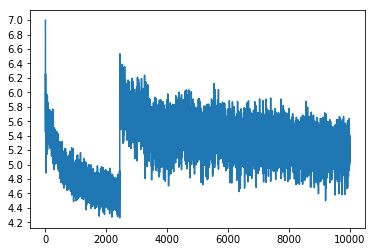

In [56]:
batches = 1000000 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(english_vocab), hidden_size)
my_decoder = AttnDecoderRNN(hidden_size, len(indo_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()


# Load the pre-trained model with teacher forcing.
"""
with open('encoder_attention_100_100000_0.5.pkl', 'rb') as fin:
    my_encoder = pickle.load(fin)
    
with open('decoder_attention_100_100000_0.5.pkl', 'rb') as fin:
    my_decoder = pickle.load(fin)
"""

# Or train a new model; un-comment the following lines

train(my_encoder, my_decoder, batches, print_every=100)
# In Python >= 3.6
with open(f'encoder_attention_{hidden_size}_{batches}_{teacher_forcing_ratio}.pkl', 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open(f'decoder_attention_{hidden_size}_{batches}_{teacher_forcing_ratio}.pkl', 'wb') as fout:
    pickle.dump(my_decoder, fout)

In [58]:
def translator(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    # The length of the input.
    input_length = input_variable.size()[0]
    # For each sentence, initilize the hidden states with zeros.
    encoder_hidden = encoder.initialize_hidden_states()
    # Initialize the encoder outputs. 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    # Iterate through the input words.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]
    # Initialize the decoder with the start symbol <s>.
    decoder_input = Variable(torch.LongTensor([[START_IDX]])) 
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # Use the last encoder hidden state as the first decoder's hidden state.
    decoder_hidden = encoder_hidden
    # Keep a list of the decoded words.
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Iterate through the decoder states.
    for di in range(max_length):
        # Very similar to how the training works.
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, 
                                                                    decoder_hidden,
                                                                    encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END_IDX:
            decoded_words.append(END_IDX)
            break
        else:
            decoded_words.append(ni.item())# changed from ni to ni.item() : Pier FIXED
        # Replace the new decoder input for the next state 
        # with the top guess of this state.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words, decoder_attentions[:di + 1]

    
def translate(english_text):
    output_words, _ = translator(my_encoder, my_decoder, variable_from_sent(english_text, english_vocab))
    print(output_words)
    output_sentence = [indo_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)



In [59]:
translate('French Muslims fined for face veils')

[1]


''

In [27]:
# Save Model
# print(hidden_size, batches)
# print(f'encoder_attention_{hidden_size}_{batches}.pkl')

# # In Python >= 3.6
# with open(f'./models/encoder_attention_{hidden_size}_{batches}.pkl', 'wb') as fout:
#     pickle.dump(my_encoder, fout)
# with open(f'./models/decoder_attention_{hidden_size}_{batches}.pkl', 'wb') as fout:
#     pickle.dump(my_decoder, fout)


100 100000
encoder_attention_100_100000.pkl
